# Analyse long timeseries of CTD data

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo
from datetime import datetime
from datetime import timedelta
import gsw

In [2]:
df = pd.read_csv('../../data/ISA_CTD/ctd_isa_all_processed.csv',index_col=0)
df

,Latitude,Longitude,Pressure,Date,Time,SA,CT
0,78.257,15.5266,1,2011-12-14 12:05:34,0.0,34.478605,0.846132
1,78.257,15.5266,2,2011-12-14 12:05:34,0.0,34.453490,0.846728
2,78.257,15.5266,3,2011-12-14 12:05:34,0.0,34.463543,0.844132
3,78.257,15.5266,4,2011-12-14 12:05:34,0.0,34.473596,0.843536
4,78.257,15.5266,5,2011-12-14 12:05:34,0.0,34.458529,0.846576
...,...,...,...,...,...,...,...
18316,78.257,15.5267,61,2018-09-12 19:15:48,212915414.0,34.696629,3.467051
18317,78.257,15.5267,62,2018-09-12 19:15:48,212915414.0,34.696934,3.464486
18318,78.257,15.5267,63,2018-09-12 19:15:48,212915414.0,34.697539,3.463017
18319,78.257,15.5267,64,2018-09-12 19:15:48,212915414.0,34.700356,3.459529


## Plot time series

In [61]:
pressure_array = np.arange(np.min(df['Pressure']),np.max(df['Pressure'])+1,1)
time_array = np.arange(np.min(df['Time']),np.max(df['Time'])+1,60*60*24*7) # 1 week spacing

Time, Pressure = np.meshgrid(time_array,pressure_array)

SA_interp = scipy.interpolate.griddata(points=(df['Time'],df['Pressure']),values=df['SA'],xi=(Time,Pressure),method='nearest')
CT_interp = scipy.interpolate.griddata(points=(df['Time'],df['Pressure']),values=df['CT'],xi=(Time,Pressure),method='nearest')

In [62]:
# Transform time to dates
start = datetime.strptime(df['Date'][0], '%Y-%m-%d %H:%M:%S')
dates_array = np.empty(len(time_array),dtype=object)
for i in range(len(dates_array)):
    dates_array[i] = start+timedelta(seconds=time_array[i])
#print(dates_array[3])
#print(dates_array[55])
#print(dates_array[107])
#print(dates_array[160])
#print(dates_array[212])
#print(dates_array[264])
#print(dates_array[316])
years_array = np.array([3,55,107,160,212,264,316])

# Transform pressure to depth
depth_array = gsw.z_from_p(pressure_array,np.mean(df['Latitude']))*-1
TimeZ,Depth = np.meshgrid(time_array,depth_array)

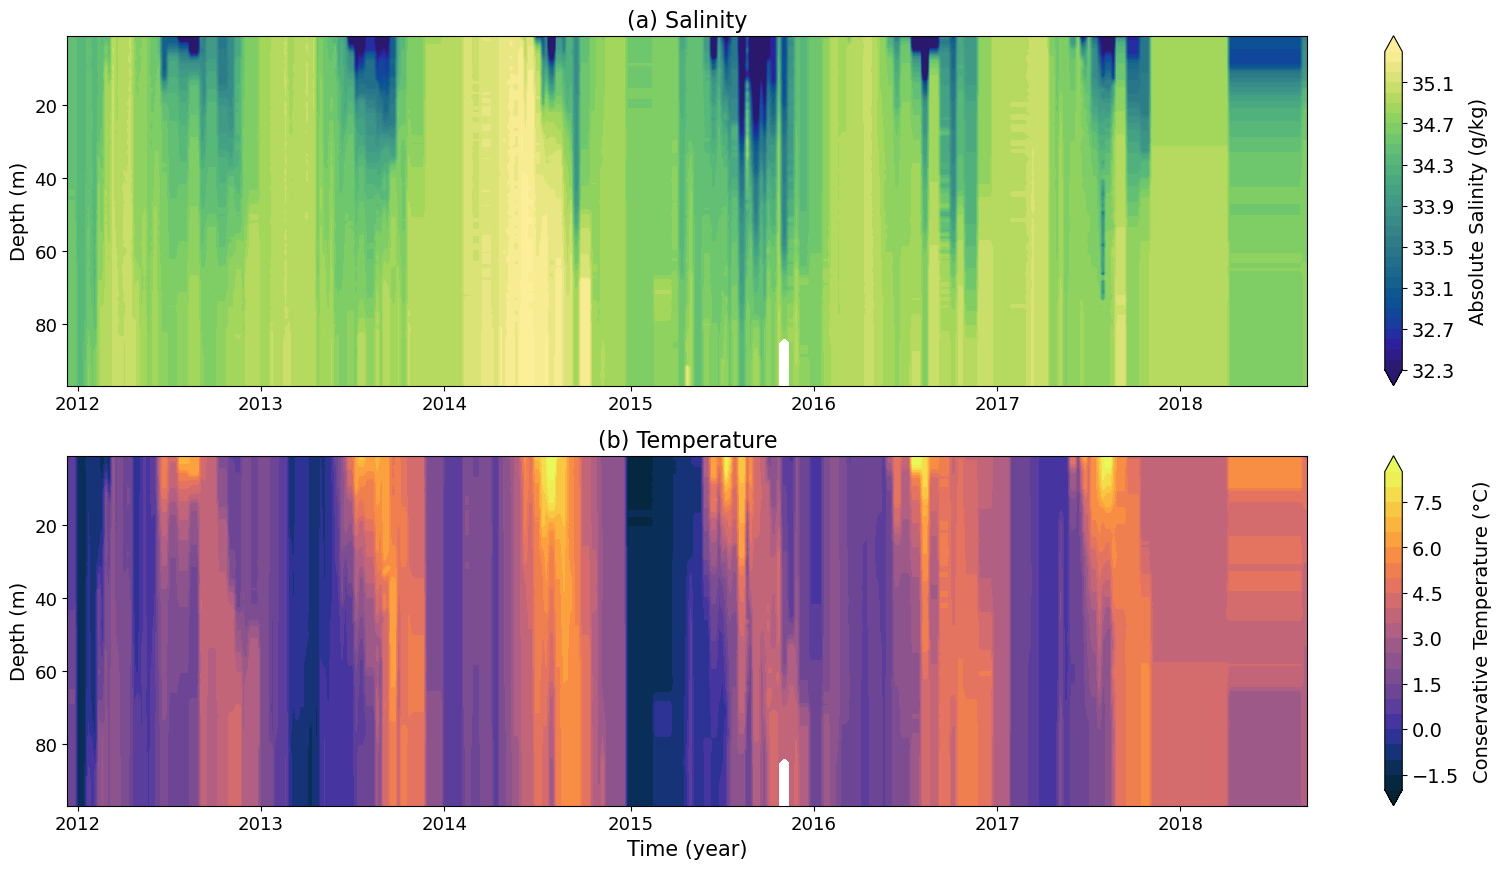

In [63]:
def plotTimeDepth(ax,Time,Vert,data,levels,cmap,label):
    plot = ax.contourf(Time,Vert,data,levels=levels,extend='both',cmap=cmap)
    cbar = plt.colorbar(plot,ax=ax)
    cbar.ax.set_ylabel(label,fontsize=14)
    cbar.ax.tick_params(axis='y', which='both', labelsize=14)
    cbar.ax.get_yaxis().labelpad = 10
    ax.tick_params(axis='both', labelsize=13)
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_xticks(time_array[years_array])
    ax.set_xticklabels([dates_array[i].year for i in years_array])
    ax.set_ylabel('Depth (m)',fontsize=14)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,10))
plotTimeDepth(ax1,TimeZ,Depth,SA_interp,levels=np.arange(32.3,35.4,0.1),cmap='cmo.haline',
              label='Absolute Salinity (g/kg)')
plotTimeDepth(ax2,TimeZ,Depth,CT_interp,levels=np.arange(-2,8.51,0.5),cmap='cmo.thermal',
              label='Conservative Temperature ('+'\u00B0'+'C)')
ax2.set_xlabel('Time (year)',fontsize=15)
ax1.set_title('(a) Salinity',fontsize=16)
ax2.set_title('(b) Temperature',fontsize=16)

#plt.savefig('../../ocean_plots/timeseries_2012_2018.png',dpi=300,bbox_inches='tight')
plt.show()

In [47]:
print('Mean latitude: %.2f N'%(np.mean(df['Latitude'])))
print('Mean longitude: %.2f E'%(np.mean(df['Longitude'])))

Mean latitude: 78.26 N
Mean longitude: 15.53 E


## Plot TS diagrams

In [108]:
import seaborn as sns
sns.set_style('white')

In [105]:
def TSdiagram(ax,Svals,Tvals,levels): #,month):
    """
    Make a TS diagram background: sigma0 contours as function of SA and CT
    """
    Tg,Sg = np.meshgrid(Tvals,Svals)
    sigma = gsw.sigma0(Sg,Tg)
    
    CS = ax.contour(Sg, Tg, sigma, linestyles='dashed', colors='grey', zorder=1, levels=levels)
    plt.clabel(CS, fontsize=13, inline=1, fmt='%0.2f')

In [106]:
def get_SA_CT(pval):
    """
    Select salinity and temperature at certain pressure level
    """
    SA_pval = df.loc[df['Pressure']==pval]['SA']
    CT_pval = df.loc[df['Pressure']==pval]['CT']
    return SA_pval, CT_pval

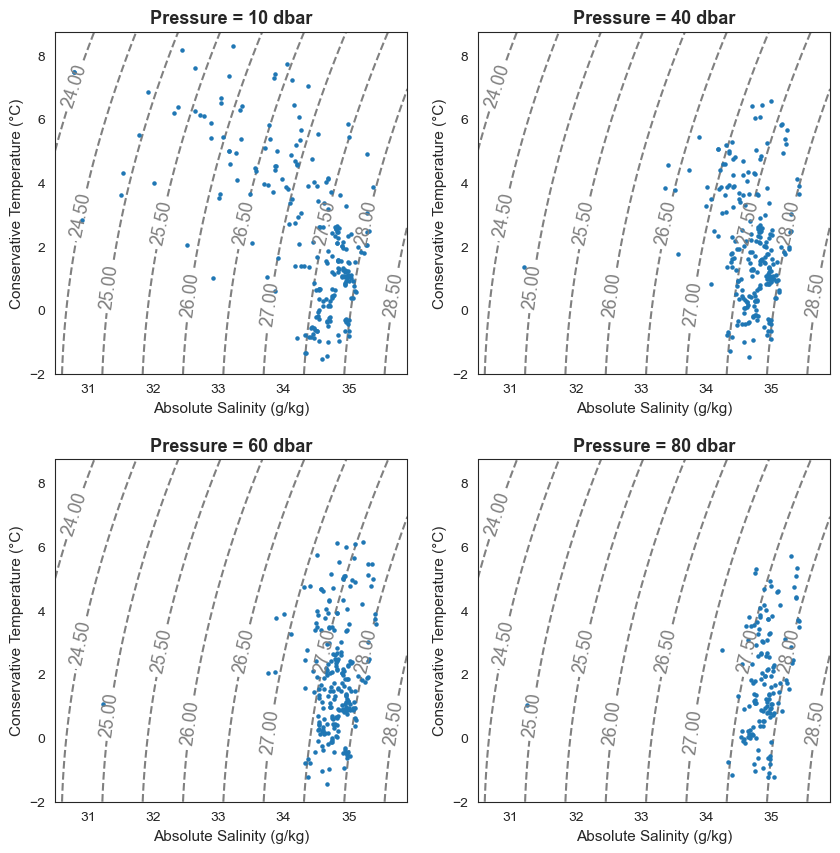

In [120]:
Svals = np.arange(30.5,36,0.1)
Tvals = np.arange(-2,9,0.25)
levels = np.arange(24,36,0.5)

def plot_TS(ax,pval):
    TSdiagram(ax,Svals,Tvals,levels)
    ax.scatter(get_SA_CT(pval)[0],get_SA_CT(pval)[1],
              s=5)
    ax.set_title('Pressure = %.f dbar'%pval,fontsize=13,fontweight='bold')
    ax.set_xlabel('Absolute Salinity (g/kg)',fontsize=11)
    ax.set_ylabel('Conservative Temperature ('+'\u00B0'+'C)',fontsize=11)


fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,10))

plot_TS(ax1,10)
plot_TS(ax2,40)
plot_TS(ax3,60)
plot_TS(ax4,80)

plt.subplots_adjust(hspace=0.25)
plt.show()

# TODO:
# - color the dots by time
# - add water masses